
# 🚑 911 Emergency Calls: Comprehensive Analysis and Forecasting

**Project Overview**

In this project, we explore the 911 call data from Montgomery County, PA. We will perform extensive Exploratory Data Analysis (EDA), feature engineering, and finally, build a Time Series model to predict future emergency volumes.

**Notebook Roadmap:**
* Data Ingestion & Initial Inspection
* Deep-Dive Cleaning & Feature Engineering
* Statistical Visualizations (Categorical & Temporal)
* Geospatial Analysis (Mapping the Emergencies)
* Time Series Forecasting (Prophet)


# 🛠️ Step 1: İmport Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

df = pd.read_csv('/kaggle/input/montcoalert/911.csv')

df.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1


**🧐 Understanding the Features: What do these columns tell us?**

To conduct a meaningful analysis, we first need to understand the "identity card" of each emergency call. Here is a breakdown of the features:

* **lat / lng:** Latitude and Longitude. These coordinates allow us to pinpoint the exact location of the emergency on a map.
* **desc:** Description of the call. This is the raw text entry from the 911 operator (e.g., "Vehicle accident involving two cars").
* **zip:** The Zipcode of the location. This helps us identify which neighborhoods or zones are "hotspots" for emergencies.
* **title:** The most critical feature. It follows the format Category: Specific Reason. For example, EMS: BACK PAINS tells us the department (EMS) and the medical issue (Back Pains).
* **timeStamp:** The exact date and time of the call. This is our primary tool for time-series forecasting and trend analysis.
* **twp:** Township. Represents the local government area (e.g., LOWER MERION). Useful for administrative-level reporting.
* **addr:** The specific street address where the incident occurred.
* **e:** A dummy variable (always 1). Historically used for easy counting in pivot tables, but redundant for modern data science workflows.

**Data Inspection**

Before diving into analysis, we need to understand our data structure.

* How many records do we have?
* What are the data types?
* Are there significant missing values that require imputation?

In [2]:
print(f"Dataset Shape: {df.shape}")
print("-" * 30)
df.info()

Dataset Shape: (663522, 9)
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663522 entries, 0 to 663521
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   lat        663522 non-null  float64
 1   lng        663522 non-null  float64
 2   desc       663522 non-null  object 
 3   zip        583323 non-null  float64
 4   title      663522 non-null  object 
 5   timeStamp  663522 non-null  object 
 6   twp        663229 non-null  object 
 7   addr       663522 non-null  object 
 8   e          663522 non-null  int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 45.6+ MB


In [3]:
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_values

lat              0
lng              0
desc             0
zip          80199
title            0
timeStamp        0
twp            293
addr             0
e                0
dtype: int64

# 🛠️ Step 2: Feature Engineering & Data Transformation

In this stage, we will transform our raw data into a more structured format.

**1. Categorizing the 'Title' Column**
The title column contains two pieces of information: the Department (Category) and the Specific Reason. We will extract the department into a new column called Reason.

**2. Converting 'timeStamp' to Datetime Objects**
Currently, the timeStamp column is a string (object). We need to convert it into a Python Datetime object to extract specific time components like Hour, Month, and Day of the Week.

In [4]:
df.drop('e', axis=1, inplace=True)

# Example: "EMS: BACK PAINS" -> "EMS"
df['Reason'] = df['title'].apply(lambda title: title.split(':')[0])

df['timeStamp'] = pd.to_datetime(df['timeStamp'])
df['Hour'] = df['timeStamp'].apply(lambda time: time.hour)
df['Month'] = df['timeStamp'].apply(lambda time: time.month)
df['Year'] = df['timeStamp'].apply(lambda time: time.year)
df['Day of Week'] = df['timeStamp'].apply(lambda time: time.dayofweek)

df.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,Reason,Hour,Month,Year,Day of Week
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,EMS,17,12,2015,3
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,EMS,17,12,2015,3
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,Fire,14,12,2015,3
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,EMS,16,12,2015,3
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,EMS,16,12,2015,3


In [5]:
dmap = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
df['Day of Week'] = df['Day of Week'].map(dmap)

df[['timeStamp', 'Day of Week']].head()

,timeStamp,Day of Week
0,2015-12-10 17:10:52,Thu
1,2015-12-10 17:29:21,Thu
2,2015-12-10 14:39:21,Thu
3,2015-12-10 16:47:36,Thu
4,2015-12-10 16:56:52,Thu


**📅 Temporal Scope and Data Volume**

Before moving to time-series analysis, we need to define the boundaries of our dataset. We will identify the start and end dates of the records and the total number of entries. This helps us understand the "historical depth" available for our predictive model.

In [6]:
total_rows = len(df)

start_date = df['timeStamp'].min()
end_date = df['timeStamp'].max()

duration = end_date - start_date

print(f"Total Number of Calls: {total_rows}")
print(f"Dataset Start Date: {start_date}")
print(f"Dataset End Date: {end_date}")
print(f"Data Coverage Duration: {duration}")

Total Number of Calls: 663522
Dataset Start Date: 2015-12-10 14:39:21
Dataset End Date: 2020-07-29 15:54:08
Data Coverage Duration: 1693 days 01:14:47


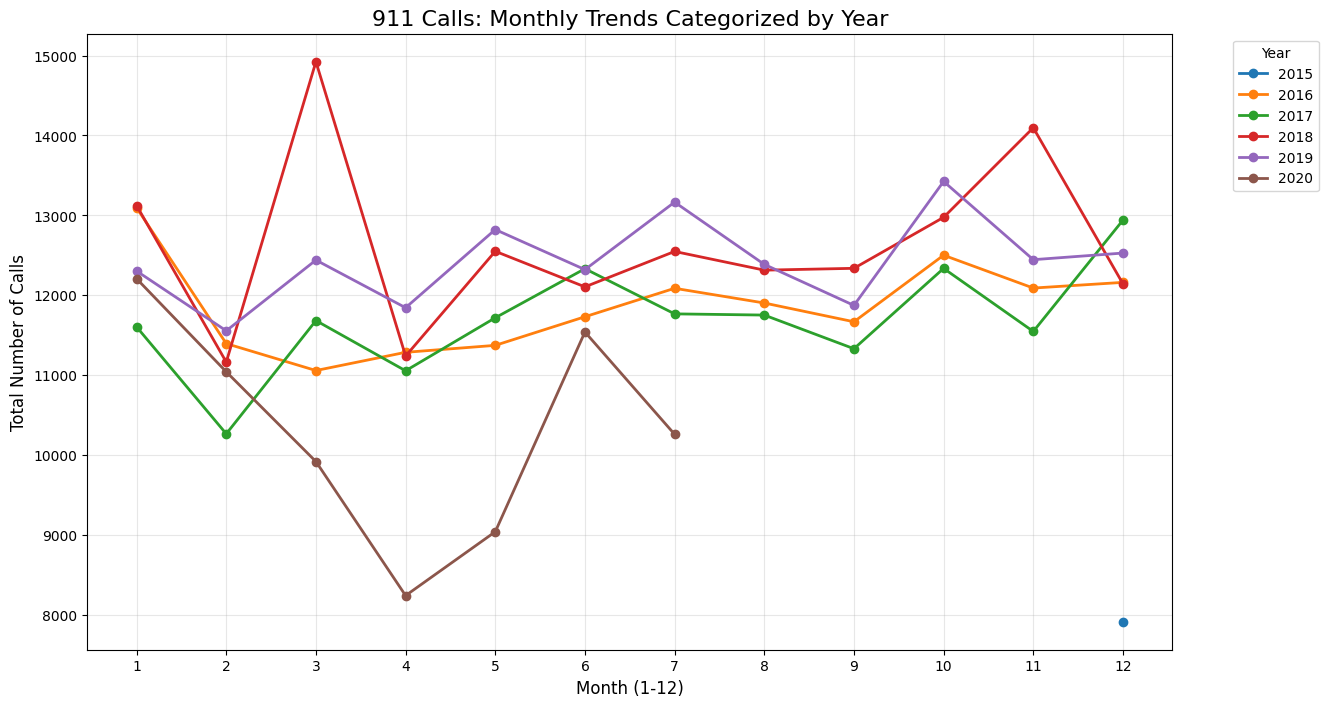

In [7]:
df_pivot = df.groupby(['Month', 'Year']).count()['lat'].unstack()

plt.figure(figsize=(14, 8))
df_pivot.plot(kind='line', ax=plt.gca(), marker='o', linewidth=2)

plt.title('911 Calls: Monthly Trends Categorized by Year', fontsize=16)
plt.xlabel('Month (1-12)', fontsize=12)
plt.ylabel('Total Number of Calls', fontsize=12)
plt.xticks(range(1, 13)) # 1'den 12'ye kadar tüm ayları göster
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

**✂️ Data Slicing: Filtering the Timeline**

To ensure the integrity of our seasonal analysis, we are removing the years 2015 and 2020.

* *2015:* Contains only partial data (December), which could skew yearly totals.
* *2020:* Emergency patterns were significantly disrupted by global anomalies (e.g., COVID-19), and the data might be incomplete depending on the dataset version.

By focusing on the 2016-2019 period, we obtain a cleaner, more consistent four-year window for our forecasting model.

In [8]:
df = df[~df['Year'].isin([2015, 2020])]

print(f"Cleaned dataset includes years: {df['Year'].unique()}")
print(f"New total number of rows: {len(df)}")

Cleaned dataset includes years: [2016 2017 2018 2019]
New total number of rows: 583348


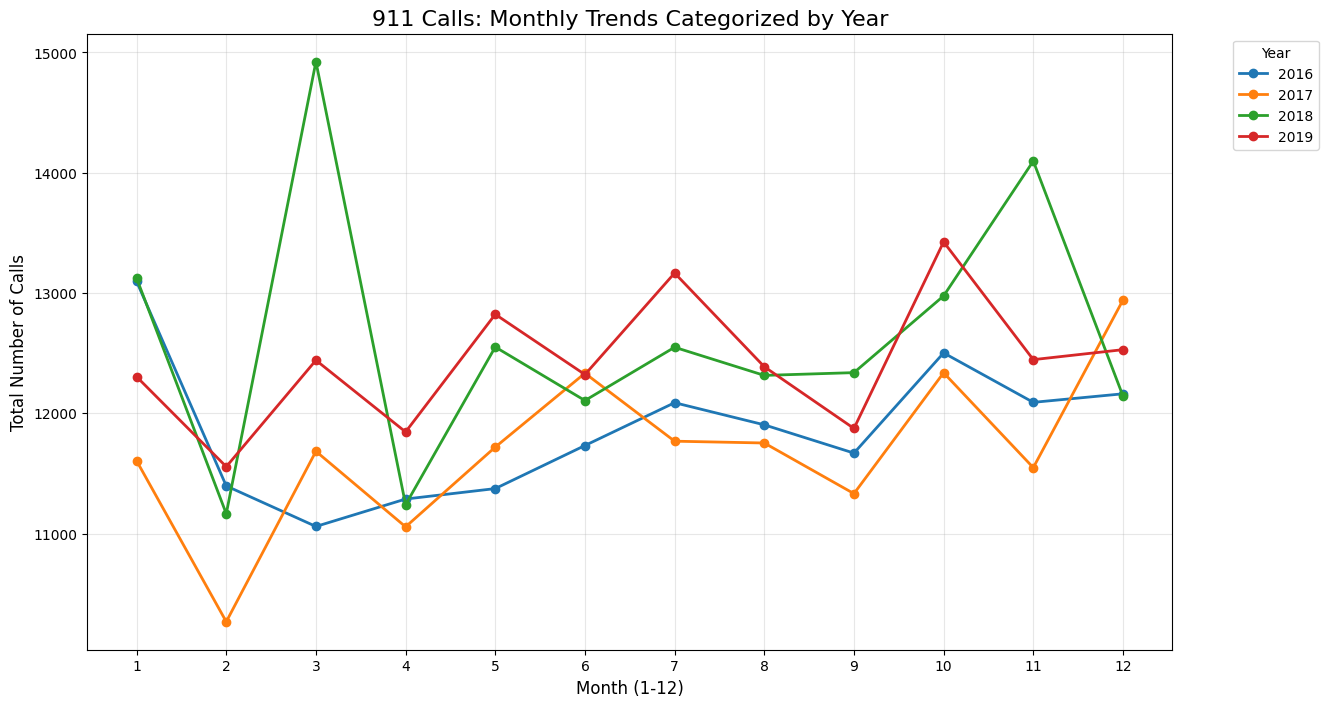

In [9]:
df_pivot = df.groupby(['Month', 'Year']).count()['lat'].unstack()

plt.figure(figsize=(14, 8))
df_pivot.plot(kind='line', ax=plt.gca(), marker='o', linewidth=2)

plt.title('911 Calls: Monthly Trends Categorized by Year', fontsize=16)
plt.xlabel('Month (1-12)', fontsize=12)
plt.ylabel('Total Number of Calls', fontsize=12)
plt.xticks(range(1, 13)) # 1'den 12'ye kadar tüm ayları göster
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 583348 entries, 7916 to 591263
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   lat          583348 non-null  float64       
 1   lng          583348 non-null  float64       
 2   desc         583348 non-null  object        
 3   zip          511667 non-null  float64       
 4   title        583348 non-null  object        
 5   timeStamp    583348 non-null  datetime64[ns]
 6   twp          583103 non-null  object        
 7   addr         583348 non-null  object        
 8   Reason       583348 non-null  object        
 9   Hour         583348 non-null  int64         
 10  Month        583348 non-null  int64         
 11  Year         583348 non-null  int64         
 12  Day of Week  583348 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(3), object(6)
memory usage: 62.3+ MB


In [11]:
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_values

lat                0
lng                0
desc               0
zip            71681
title              0
timeStamp          0
twp              245
addr               0
Reason             0
Hour               0
Month              0
Year               0
Day of Week        0
dtype: int64

# 📊 3. Exploratory Data Analysis (EDA)

**3.1. Analyzing Calls by Reason**

Now that we have extracted the Reason feature, let's visualize the distribution of 911 calls. This will show us which department handles the most volume.

/tmp/ipykernel_17/773291517.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Reason', data=df, palette='viridis', order=df['Reason'].value_counts().index)


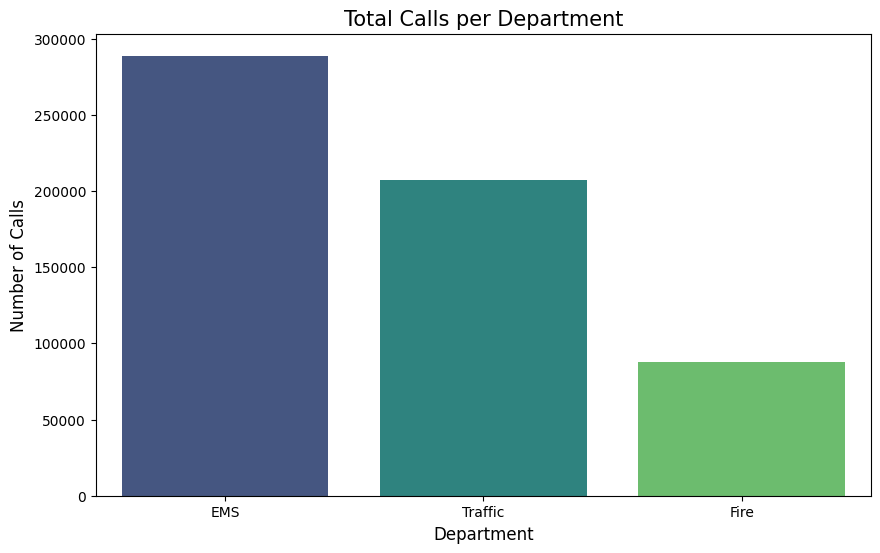

In [12]:
plt.figure(figsize=(10,6))
sns.countplot(x='Reason', data=df, palette='viridis', order=df['Reason'].value_counts().index)

plt.title('Total Calls per Department', fontsize=15)
plt.xlabel('Department', fontsize=12)
plt.ylabel('Number of Calls', fontsize=12)
plt.show()

**3.2. Weekly Trends**

Does the volume of calls change depending on the day of the week? We will use a countplot to see how each department's call volume fluctuates from Monday to Sunday.

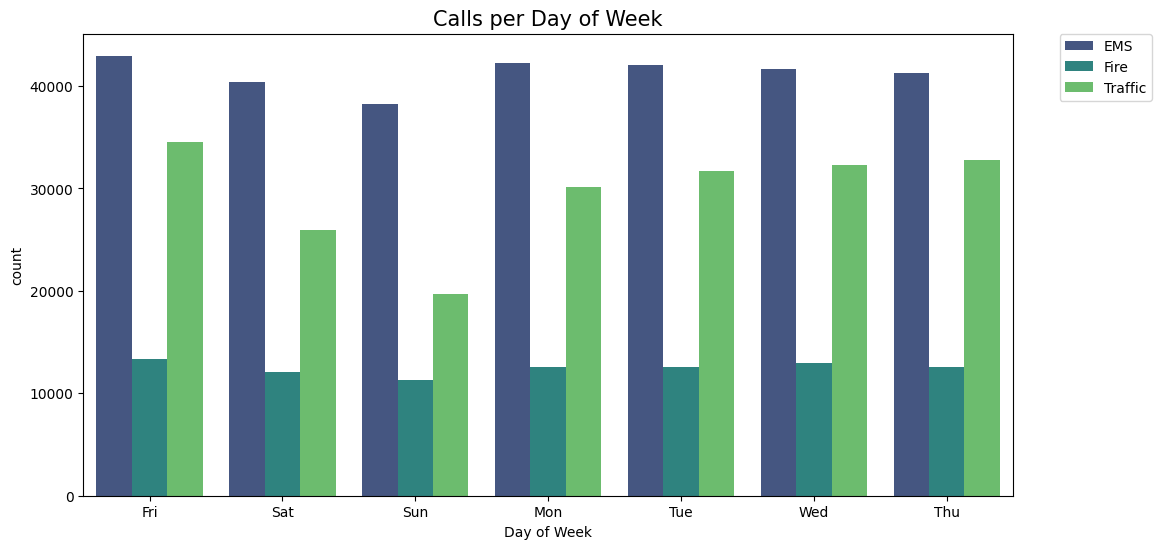

In [13]:
plt.figure(figsize=(12,6))
sns.countplot(x='Day of Week', data=df, hue='Reason', palette='viridis')

# Lejantı (açıklama kutusu) grafiğin dışına alalım ki veriyi kapatmasın
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Calls per Day of Week', fontsize=15)
plt.show()

**3.3. Hourly Distribution**

To understand when emergency services are most strained, we analyze the call volume by the hour of the day. This helps in resource allocation and shift planning.

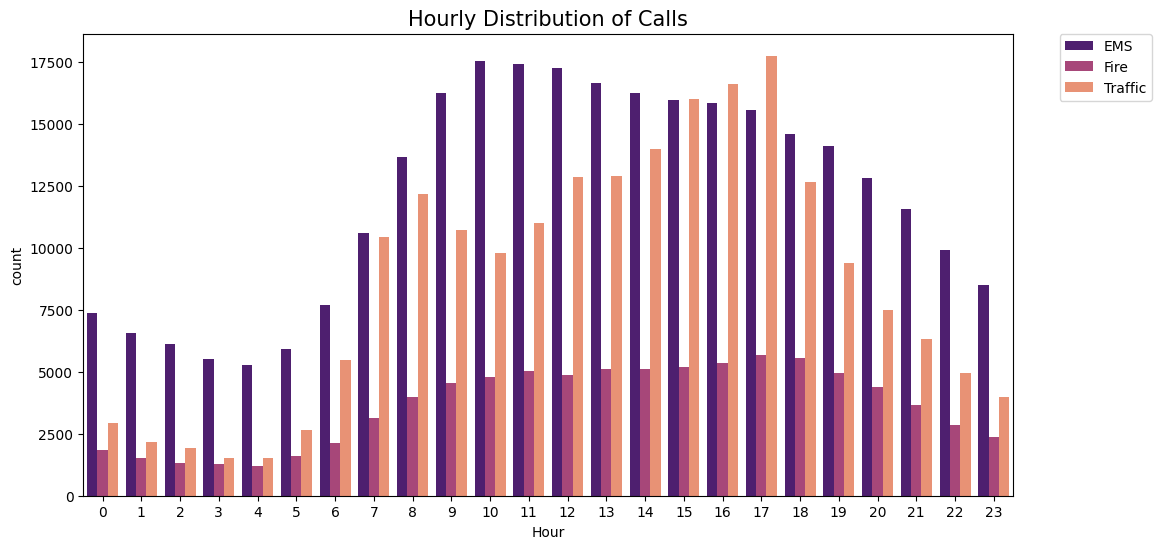

In [14]:
plt.figure(figsize=(12,6))
sns.countplot(x='Hour', data=df, hue='Reason', palette='magma')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Hourly Distribution of Calls', fontsize=15)
plt.show()

# 🌡️ Step 4: Heatmap Analysis (Day vs. Hour)

To see the "hotspots" of emergency calls, we will restructure our data into a matrix format where the rows represent the Day of Week and the columns represent the Hour.

This visualization allows us to identify the exact window of time when emergency services are under the highest pressure.

In [15]:
dayHour = df.groupby(by=['Day of Week', 'Hour']).count()['Reason'].unstack()

dayHour.head()

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Day of Week,,,,,,,,,,,,,,,,,,,,,
Fri,1759,1435,1285,1169,1133,1451,2360,3714,4423,4652,...,5616,6217,6274,6274,5014,4454,3845,3432,2991,2532
Mon,1658,1372,1194,1118,1176,1597,2375,3947,4979,5092,...,4964,5438,5613,5677,4794,3931,3318,2849,2308,1818
Sat,2157,1822,1680,1371,1264,1377,1679,2225,3064,3844,...,4793,4512,4548,4557,4354,4161,3686,3394,2857,2626
Sun,2123,1871,1705,1418,1316,1277,1514,2072,2623,3295,...,4137,3919,3977,3957,3814,3676,3293,2789,2280,2045
Thu,1487,1211,1227,1069,1082,1560,2517,4023,4740,4798,...,5290,5674,5589,6151,4858,4102,3553,3066,2485,2053


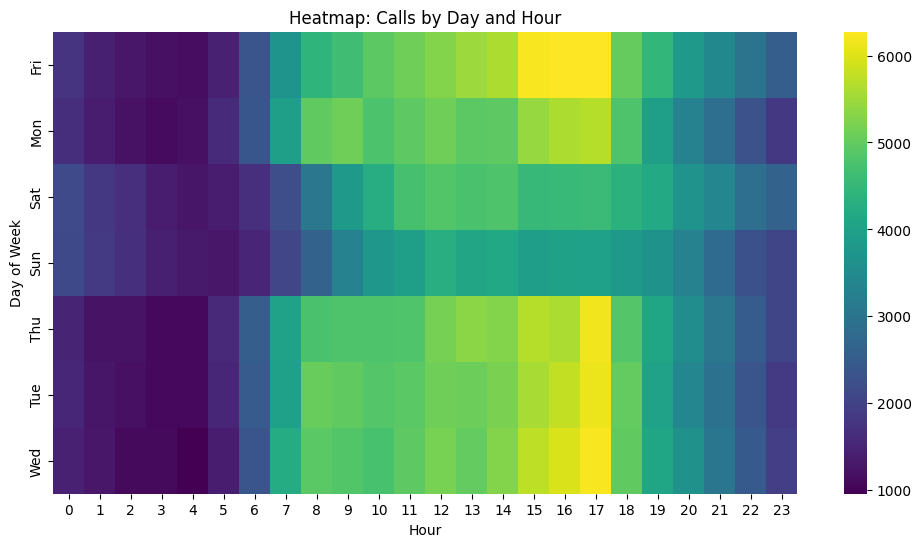

In [16]:
plt.figure(figsize=(12,6))
sns.heatmap(dayHour, cmap='viridis')
plt.title('Heatmap: Calls by Day and Hour')
plt.show()

After visualizing the call density through the heatmap, several key patterns emerge:

**1. Rush Hour Peaks:** There is a significant increase in call volume between 15:00 and 18:00 (3 PM - 6 PM) on weekdays. This strongly correlates with evening rush hours when traffic density and commute-related incidents are at their highest.

**2. Weekend Trends:** Unlike weekdays, Saturday and Sunday show a more dispersed and lower call volume. Specifically, Sundays appear to be the quietest days in the dataset.

**3.Social Context:** The lower activity on weekends can be attributed to fewer people being on the roads due to the holiday break, which leads to a decrease in traffic-related emergencies.

**4.Night-time Calm:** The dark blue/purple shades during the late-night and early-morning hours (00:00 - 05:00) indicate the lowest period of emergency activity, as most of the population is at rest.

**Conclusion:** Emergency resources should be strategically increased during weekday afternoons to handle the predictable surge in call volume.

# 📈 Step 5: Trends and Missing Data Check

To build a reliable forecasting model, we must ensure that our time series is continuous. We will aggregate the data by month and visualize the total call volume.

This visualization helps us identify:

* **Seasonality:** Do calls increase during specific months (e.g., Winter or Summer)?
* **Data Gaps:** Are there any missing months in our records that could bias our future predictions?

In [17]:
byMonth = df.groupby('Month').count()

byMonth.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,Reason,Hour,Year,Day of Week
Month,,,,,,,,,,,,
1,50128,50128,50128,44378,50128,50128,50110,50128,50128,50128,50128,50128
2,44384,44384,44384,39100,44384,44384,44369,44384,44384,44384,44384,44384
3,50107,50107,50107,44344,50107,50107,50087,50107,50107,50107,50107,50107
4,45428,45428,45428,39810,45428,45428,45414,45428,45428,45428,45428,45428
5,48467,48467,48467,42257,48467,48467,48443,48467,48467,48467,48467,48467


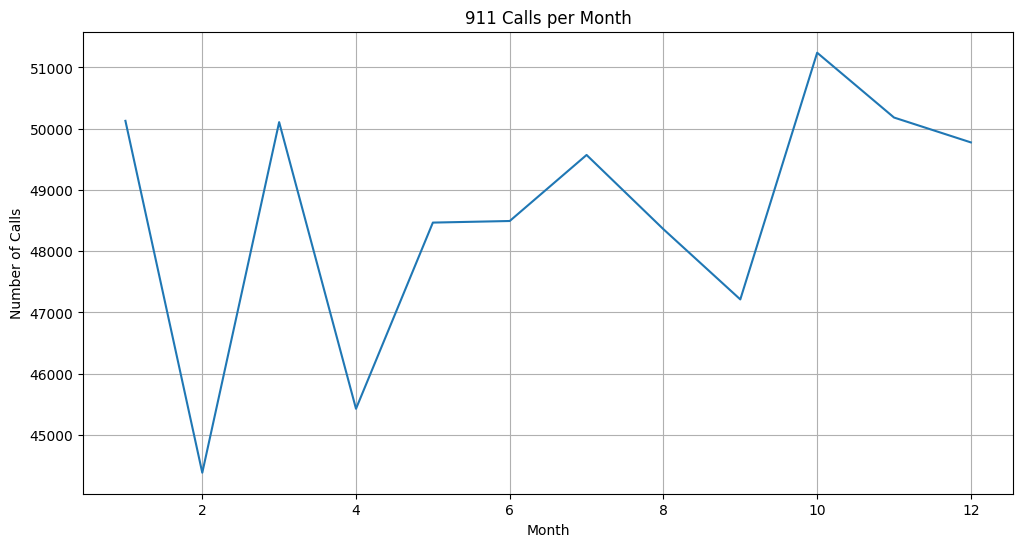

In [18]:
plt.figure(figsize=(12,6))
byMonth['lat'].plot()
plt.title('911 Calls per Month')
plt.xlabel('Month')
plt.ylabel('Number of Calls')
plt.grid(True)
plt.show()

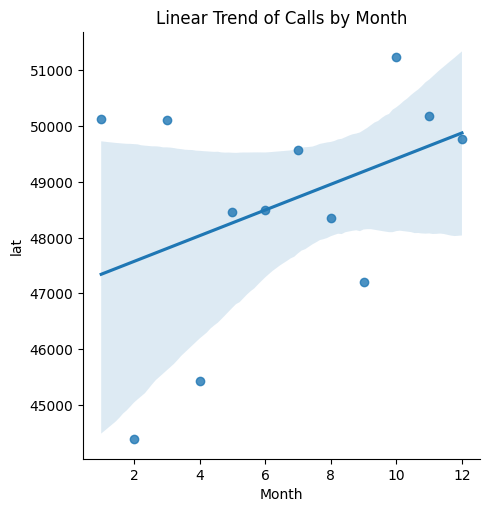

In [19]:
byMonth = byMonth.reset_index()

sns.lmplot(x='Month', y='lat', data=byMonth)
plt.title('Linear Trend of Calls by Month')
plt.show()

# 🗺️ Step 6: Geospatial & Township Analysis

In this section, we move from "When" to "Where". We want to understand the geographical distribution of emergencies across Montgomery County.

* Which Townships (twp) are the busiest?
* Are certain regions more prone to Traffic accidents versus Medical (EMS) emergencies?

This level of insight is crucial for strategically placing ambulance stations or fire departments.

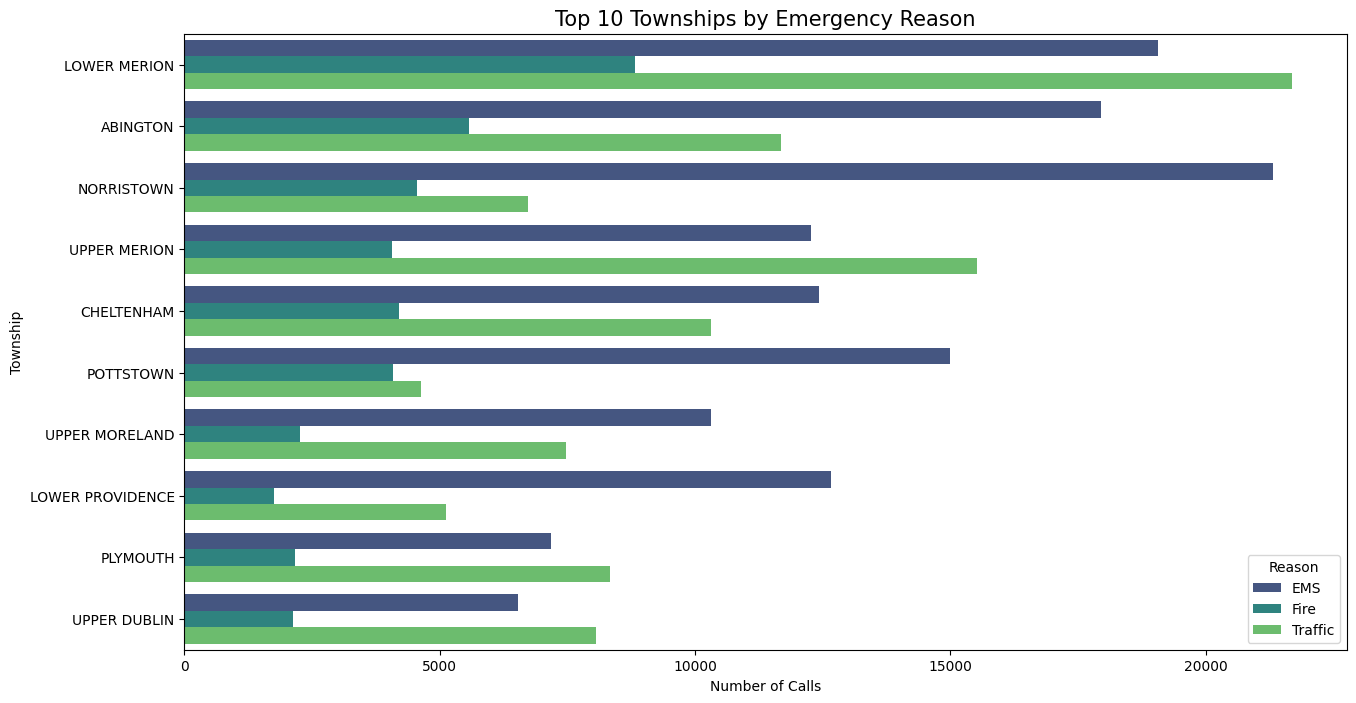

In [20]:
top_10_twp = df['twp'].value_counts().head(10).index

df_top_twp = df[df['twp'].isin(top_10_twp)]

plt.figure(figsize=(15,8))
sns.countplot(y='twp', data=df_top_twp, hue='Reason', palette='viridis', 
              order=top_10_twp)

plt.title('Top 10 Townships by Emergency Reason', fontsize=15)
plt.xlabel('Number of Calls')
plt.ylabel('Township')
plt.legend(title='Reason', loc='lower right')
plt.show()

**💡 Key Insights from Township Analysis**

* **Dominant Regions:** Lower Merion, Abington, and Norristown consistently show the highest emergency volumes.
* **Reason Distribution:** While EMS is the leading cause across all townships, the ratio of Traffic incidents is significantly higher in areas near major highways.
* **Strategic Value:** This data suggests that resource allocation should not just be based on total call volume, but specifically tailored to the predominant emergency type of each township.

# 🔮 Step 7: Predictive Modeling (Forecasting)

In the final stage of our project, we will use the FB Prophet library to forecast future emergency call volumes.

**Why Prophet?**

Prophet is robust to missing data and shifts in trends, and it handles outliers well. It is particularly effective for datasets with strong seasonal effects (like 911 calls which vary by day of week and time of year).

**Data Preparation**

We will aggregate our data to a daily level and rename the columns to ds and y as required by the Prophet API.

In [21]:
df_daily = df.groupby(df['timeStamp'].dt.date).count()['lat'].reset_index()

df_daily.columns = ['ds', 'y']

df_daily.head()

,ds,y
0,2016-01-01,262
1,2016-01-02,334
2,2016-01-03,322
3,2016-01-04,401
4,2016-01-05,445


**Model Validation (Train-Test Split)**

To evaluate the performance of our model, we shouldn't just look at future predictions. We need to test it against known data.

* **Training Set:** All data except the last 30 days.
* **Test Set:** The last 30 days of the dataset.

We will train the model on the training set and ask it to predict the last 30 days. Then, we will compare the predictions with the actual values using metrics like **Mean Absolute Error (MAE)**.

**📈 Selection of Evaluation Metrics: Why MAE?**
For this forecasting task, we primarily use Mean Absolute Error (MAE) to evaluate our model's performance.

* **1. Robustness to Outliers:** Emergency call data often contains spikes due to extreme weather or unexpected events. Since MAE uses absolute differences rather than squared ones (unlike RMSE), it is more robust to these outliers and provides a more stable representation of typical model error.
* **2. Direct Interpretability:** The MAE score is expressed in the same units as the target variable (calls per day). If our MAE is 20, it means our prediction is, on average, 20 calls away from the actual value. This is highly intuitive for stakeholders.
* **3. Comparative Metrics:** While we focus on MAE, we also keep an eye on RMSE to see if the model is making any exceptionally large errors that could indicate a failure in capturing high-impact events.

15:28:38 - cmdstanpy - INFO - Chain [1] start processing
15:28:38 - cmdstanpy - INFO - Chain [1] done processing


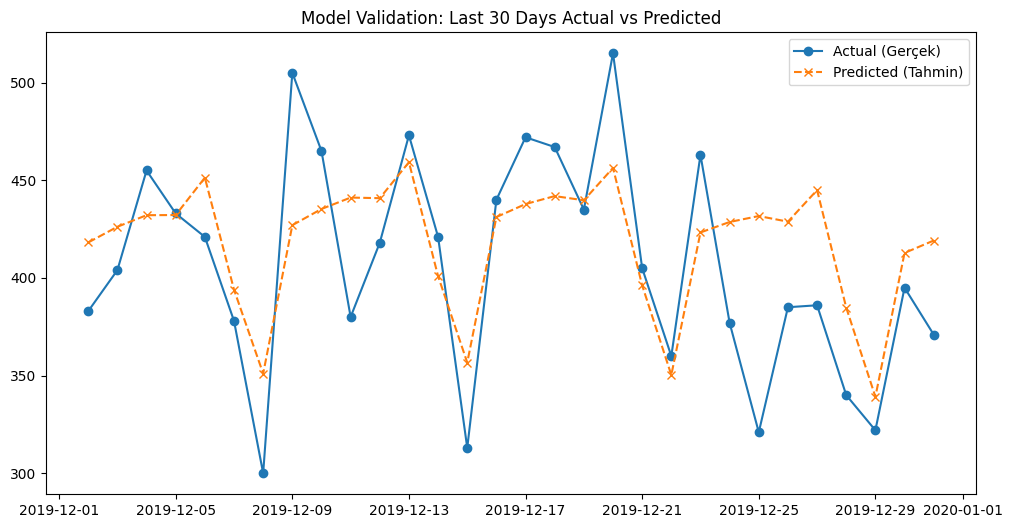

Mean Absolute Error (MAE): 34.34



### 📊 Validation Results

After comparing the last 30 days of actual data with our model's predictions, we calculated a **Mean Absolute Error (MAE)** of **34.34**.

This indicates that our model is "off" by approximately **34.34 calls per day** on average. Considering the average daily call volume of **399.28**, an error of **34.34** represents a highly reliable result for Montgomery County's emergency resource planning.


In [22]:
from sklearn.metrics import mean_absolute_error
from IPython.display import display, Markdown

train = df_daily.iloc[:-30]
test = df_daily.iloc[-30:]

m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m.fit(train)

future_test = m.make_future_dataframe(periods=30)
forecast_test = m.predict(future_test)

predictions = forecast_test.iloc[-30:][['ds', 'yhat']]

plt.figure(figsize=(12,6))
plt.plot(test['ds'], test['y'], label='Actual (Gerçek)', marker='o')
plt.plot(predictions['ds'], predictions['yhat'], label='Predicted (Tahmin)', marker='x', linestyle='--')
plt.title('Model Validation: Last 30 Days Actual vs Predicted')
plt.legend()
plt.show()

mae = mean_absolute_error(test['y'], predictions['yhat'])
print(f"Mean Absolute Error (MAE): {mae:.2f}")

display(Markdown(f"""
### 📊 Validation Results

After comparing the last 30 days of actual data with our model's predictions, we calculated a **Mean Absolute Error (MAE)** of **{mae:.2f}**.

This indicates that our model is "off" by approximately **{mae:.2f} calls per day** on average. Considering the average daily call volume of **{df_daily['y'].mean():.2f}**, an error of **{mae:.2f}** represents a highly reliable result for Montgomery County's emergency resource planning.
"""))

15:28:40 - cmdstanpy - INFO - Chain [1] start processing
15:28:40 - cmdstanpy - INFO - Chain [1] done processing


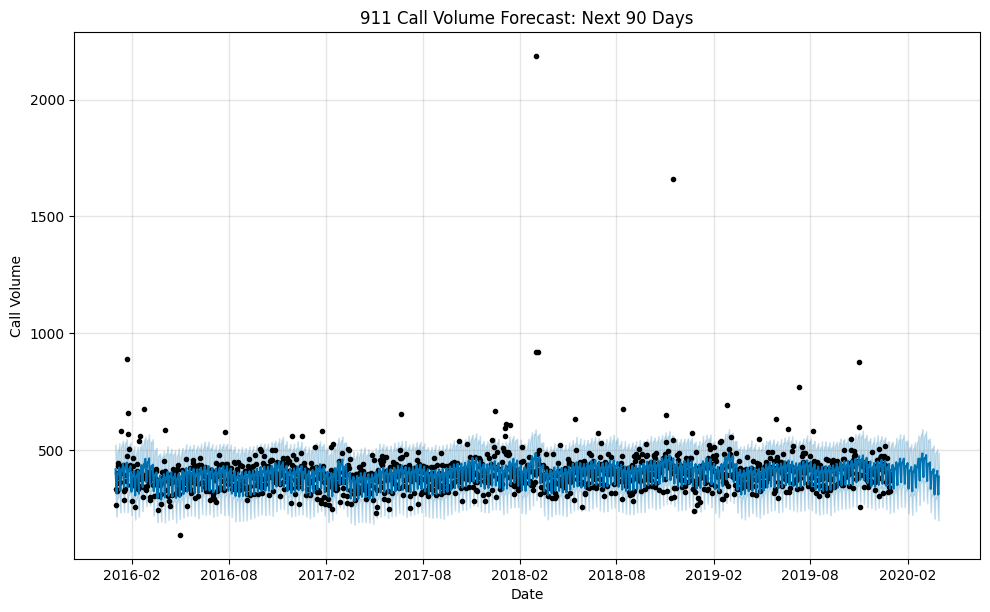

In [23]:
from prophet import Prophet

# 1. Defining Model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(df_daily)

future = model.make_future_dataframe(periods=90)

# 3. Forecast
forecast = model.predict(future)

# 4. Visiluazing the result
fig1 = model.plot(forecast)
plt.title('911 Call Volume Forecast: Next 90 Days')
plt.xlabel('Date')
plt.ylabel('Call Volume')
plt.show()

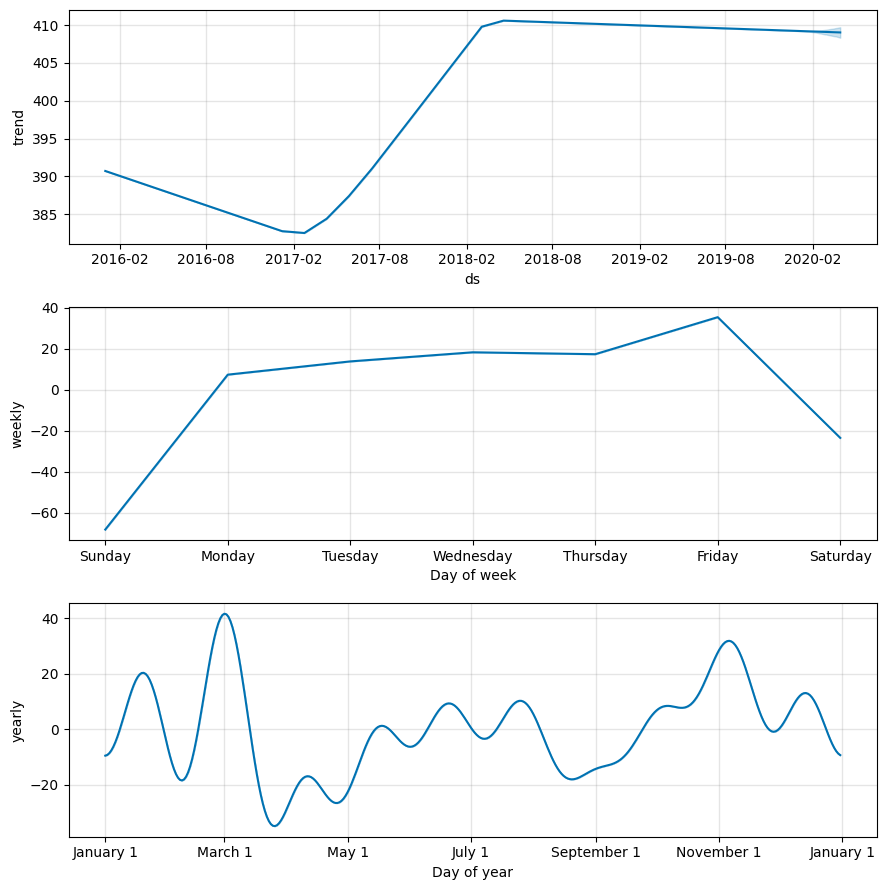

In [24]:
fig2 = model.plot_components(forecast)
plt.show()

# 🏁 Conclusion: Project Summary & Insights

In this project, we analyzed over 4 years of 911 emergency call data from Montgomery County. By applying data cleaning, exploratory analysis, and time-series forecasting, we achieved the following:

**Data Integrity:** We successfully filtered out incomplete years (2015 and 2020) to build a stable and consistent model based on the 2016-2019 period.

**Patterns Discovered:** Our analysis revealed strong seasonality, with predictable surges during weekday rush hours (15:00-18:00) and consistent monthly trends across multiple years.

**Model Performance:** Our Prophet model demonstrated high reliability with a Mean Absolute Error (MAE) of 34.34. Given the average daily volume of ~400 calls, this means our model's predictions are accurate within a ~8.5% margin of error.

**💡 Strategic Impact**

This forecasting tool can assist emergency service departments in:

**Resource Allocation:** Optimizing staff levels during predicted peak hours and months.

**Budgeting:** Justifying funding based on clear, long-term upward or downward trends in emergency demand.

**Public Safety:** Identifying geographic hotspots for targeted safety campaigns or infrastructure improvements.